In [1]:
%load_ext autoreload
%autoreload 2

%reload_ext autoreload

In [ ]:
# !git status

In [ ]:
# !git pull

In [35]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))
!git commit -m "confirm rotation works on non-hd display" Screen_new.ipynb

<IPython.core.display.Javascript object>

[development e0a935f] confirm rotation works on non-hd display
 1 file changed, 1031 insertions(+), 950 deletions(-)
 rewrite epdlib/Screen_new.ipynb (88%)


In [ ]:
!git push

In [2]:
import logging
from PIL import Image, ImageDraw
import time


In [3]:
# import pkgutil

# import importlib
# import inspect

# import waveshare_epd
# from importlib import import_module
# non_hd = []
# for i in pkgutil.iter_modules(waveshare_epd.__path__):
#     non_hd.append(i.name)


# for i in non_hd:
    
#     if i.startswith('epd') and not i.startswith('epdconfig'):
#         print(i)
#         myepd = import_module(f'waveshare_epd.{i}')
#         try:
#             print('display: ',inspect.getfullargspec(myepd.EPD.display).args)
#         except AttributeError:
#             try:
#                 print('DISPLAY: ', inspect.getfullargspec(myepd.EPD.Display).args)
#             except AttributeError:
#                 print('display: unknown')
#         try:
# #             print('clear: ', inspect.getfullargspec(myepd.EPD.clear).args)
# #         except AttributeError:
#             print('CLEAR: ', inspect.getfullargspec(myepd.EPD.Clear).args)
#         except AttributeError:
#             print('clear: unknown')
            
#         print('\n')

In [4]:
def strict_enforce(*types):
    """strictly enforce type compliance within classes
    
    Usage:
    @strict_enforce(type1, type2, (type3, type4))
    def foo(val1, val2, val4):
        ...
    """
    def decorator(f):
        def new_f(self, *args, **kwds):
            #we need to convert args into something mutable   
            newargs = []        
            for (a, t) in zip(args, types):
                if not isinstance(a, t):
                    raise TypeError(f'"{a}" is not type {t}')
#                 newargs.append( t(a)) #feel free to have more elaborated convertion
            return f(self, *args, **kwds)
        return new_f
    return decorator

In [5]:
class ScreenError(Exception):
    pass

In [6]:
class Update:
    """Class for creating a montotonicaly aware object that records passage of time
    
    create an update aware object:
        myObj = Update()
        
    Time since creation:
        myObj.age
        
    Time since last updated:
        myObj.last_updated
        
    
    Update the object:
        myObj.update = True"""
    
    def __init__(self):
        '''constructor for Update class
        
        Properties:
            start (float): floating point number in CLOCK_MONOTONIC time.
                this is a fixed point in time the object was created
            update (boolean): indicates that the object has been updated'''
            
        self.start = self.now
        self.update()
        
    @property
    def age(self):
        """age of the object in seconds since created"""
        return self.now - self.start
    
    @property
    def now(self):
        """time in CLOCK_MONOTONIC time"""
        return time.clock_gettime(time.CLOCK_MONOTONIC)
    
    @property
    def last_updated(self):
        """seconds since object was last updated"""
        return self.now - self._last_updated
    
#     @last_updated.setter
    def update(self):
        """update the object   
        Args:
            update(boolean): True updates object"""
        self._last_updated = self.now
    

In [26]:
class Screen():
    def __init__(self, epd='None', rotation=0, mode='1', vcom=0.0):
        self.vcom = vcom
        self.one_bit_display = True
        self.constants = None
        self.mode = mode
        self.image = None
        self.hd = False
        self.resolution = []
        self.HD = False
        self.epd = epd
        self.rotation = rotation
        
        
    @property
    def vcom(self):
        return self._vcom

    @vcom.setter
    @strict_enforce(float)
    def vcom(self, vcom):
        if vcom==0:
            self._vcom = None
        elif vcom > 0:
            raise ValueError(f'vcom must be a negative float value: {vcom}')
        else:
            self._vcom = vcom

    @property
    def rotation(self):
        return self._rotation
    
    @rotation.setter
    @strict_enforce(int)
    def rotation(self, rotation):
        if rotation not in [-90, 0, 90, 180, 270]:
            raise ValueError(f'valid rotation values are [-90, 0, 90, 180, 270]')
        
        if rotation in [90, -90, 270]:
            resolution = self.resolution
            resolution.sort()
            self.resolution = resolution
        else:
            resolution = self.resolution
            resolution.sort(reverse=True)
            self.resolution = resolution
            
        self.image = Image.new('L', self.resolution, 255)
        if not self.HD:
            self.buffer_no_image = self.epd.getbuffer(self.blank_image())

        self._rotation = rotation
        logging.debug(f'rotation={rotation}, resolution={self.resolution}')
            
    @property
    def epd(self):
        return self._epd

    @epd.setter
    @strict_enforce(str)
    def epd(self, epd):
        myepd = None
        if epd=='HD':
            if not self.vcom:
                raise ScreenError('no vcom value is set (see the cable on your display for a vcom value)')
            self.HD = True
            myepd = self._epd_hd(epd)
            
        elif epd == 'None':
            myepd = None
        else:
            myepd = self._epd_non_hd(epd)

        if myepd:
            # set the resolution 
            self._epd = myepd['epd']
            resolution = myepd['resolution']
            resolution.sort(reverse=True)
            self.resolution = resolution
            self.clear_args = myepd['clear_args']
            self.constants = myepd['constants']
            self.one_bit_display = myepd['one_bit_display']
            
            logging.debug(f'epd configuration: {myepd}')
            
            # set a blank image as default
            self.image = Image.new('L', self.resolution, 255)
            if self.HD:
                self.buffer_no_image = []
            else:
                self.buffer_no_image = self.epd.getbuffer(self.blank_image())
        else:
            logging.warning('no valid epd is currently configured')
            
    def initEPD(self):
        '''init the EPD for writing'''
        if not self.epd:
            raise UnboundLocalError('no epd object has been assigned')
            
        if self.HD:
            self._epd.epd.run()
        else:
            try:
                self.epd.init()
            except FileNotFoundError as e:
                raise ScreenError('failed to open SPI bus - is spi enabled in raspi-config?')
#                 logging.error(f'failed to init epd: {e}: error: {type(e)}')

        logging.info(f'epd initialized')
            
        return True            

    def clearEPD(self):
        if self.HD:
            self._epd.epd.run()
            self._epd.clear()
        else:
            try:
                self.initEPD()
                self.epd.Clear(**self.clear_args)
            # FIXME -- more explicit output here on failure
            except Exception as e:
                logging.error(f'failed to clear epd: {e}')
                return False
        return True
        
    
    def blank_image(self):
        '''generate PIL image that is entirely blank'''
        return Image.new(self.mode, self.resolution, 255)
            
            

    def writeEPD(self, image=None, sleep=True):
        '''write an image to the screen after clearing previous
        
            Non-hd screens should be put to sleep after writing to prevent
            damage to the panel.
        
        Args:
            image(PIL image): image to display
            sleep(bool) Put display to sleep after updating
            
            '''
        if not image:
            raise ScreenError('No image provided')
            
        if not self.epd:
            raise UnboundLocalError('no epd has been assigned')
        
        image = image.rotate(self.rotation, expand=True)
#         if self.rotation in [180, -90]:
#             image = image.rotate(180)
        
        if self.HD:
            self._writeEPD_hd(image, sleep)
        else:
            self._writeEPD_non_hd(image, sleep)
            
        
    
    def _writeEPD_hd(self, image, sleep):
        '''redraw entire screen, no partial update with waveform GC16
        
            see: https://www.waveshare.net/w/upload/c/c4/E-paper-mode-declaration.pdf for display modes'''
        # create a blank buffer image to write into
        self.epd.frame_buf.paste(0xFF, box=(0, 0, self.resolution[0], self.resolution[1]))
        
        self.epd.frame_buf.paste(image, [0,0])


        self.epd.frame_buf.paste(image, [0, 0])

        self.initEPD()
        logging.debug('writing to display using GC16 (full display update)')
        self.epd.draw_full(s.constants.DisplayModes.GC16)
        if sleep:
            logging.debug('putting display to sleep')
            self.epd.epd.sleep()
            
        return True
        
    def _writeEPD_non_hd(self, image, sleep):
        '''redraw entire screen'''
        image_buffer = self.epd.getbuffer(image)
        self.initEPD()
        if self.one_bit_display:
            self.epd.display(image_buffer)
        else:
            # send a blank image to colored layer
            self.epd.display(image_buffer, self.buffer_no_image)
        
        return True
        
    
    def _epd_hd(self, epd):
        from IT8951.display import AutoEPDDisplay
        from IT8951 import constants as constants_HD
        myepd = AutoEPDDisplay(vcom=self.vcom)
        resolution = list(myepd.display_dims)
        clear_args = {}
        one_bit_display = False
        
        return {'epd': myepd, 
                'resolution': resolution, 
                'clear_args': clear_args, 
                'one_bit_display': one_bit_display,
                'constants': constants_HD}    
                    
    def _epd_non_hd(self, epd):
        import waveshare_epd
        import pkgutil
        import inspect
        from importlib import import_module
        non_hd = []
        for i in pkgutil.iter_modules(waveshare_epd.__path__):
            non_hd.append(i.name)

        if epd in non_hd:
            myepd = import_module(f'waveshare_epd.{epd}')
            resolution = [myepd.EPD_HEIGHT,myepd.EPD_WIDTH]
            
            # set kwargs for screens that expect color or mode arguments to the clear function
            try:
                clear_args_spec = inspect.getfullargspec(myepd.EPD.Clear)
            except AttributeError:
                raise ScreenError(f'"{epd}" has an unsupported `EPD.Clear()` function')
            clear_args = {}
            if 'color' in clear_args_spec:
                clear_args['color'] = 0xFF
                
            try:
                display_args_spec = inspect.getfullargspec(myepd.EPD.display)
            except AttributeError:
                raise ScreenError(f'"{epd}" has an unsupported `EPD.display()` function and is not usable with this module')
            
            logging.debug(f'args_spec: {display_args_spec.args}')
            if len(display_args_spec.args) <= 2:
                one_bit_display = True
            else:
                one_bit_display = False
            
        else:
            raise ScreenError(f'invalid waveshare module: {epd}')
            
        return {'epd': myepd.EPD(), 
                'resolution': resolution, 
                'clear_args': clear_args,
                'one_bit_display': one_bit_display,
                'constants': None}

In [23]:
# # # add this to the hd write function
# s.epd.frame_buf.paste(0xFF, box=(0, 0, s.epd.width, s.epd.height))

# i = mylayout_hd.concat()
# s.epd.frame_buf.paste(i, [0, 0])

# s.initEPD()
# s.epd.draw_full(s.constants.DisplayModes.GC16)
# # s.epd.clear()

In [24]:
# s.epd.clear()
# s.epd.epd.sleep()

In [10]:
import Layout

In [11]:
l = {
    'text_a': {
        'image': None,
        'padding': 10, 
        'width': 1,
        'height': 1/4,
        'abs_coordinates': (0, 0),
        'mode': 'L',
        'font': './fonts/Open_Sans/OpenSans-ExtraBold.ttf',
        'max_lines': 1,
        'font_size': None,
        'fill': 128},
    
    'text_b': {
        'image': None,
        'padding': 10,
        'inverse': True,
        'width': 1,
        'height': 1/4,
        'abs_coordinates': (0, None),
        'relative': ['text_b', 'text_a'],
        'mode': 'L',
        'font': './fonts/Open_Sans/OpenSans-ExtraBold.ttf',
        'max_lines': 3,
        'font_size': None},
    
    'image_a': {
        'image': True,
        'width': 1/2,
        'height': 1/2,
        'mode': 'L',
        'abs_coordinates': (0, None),
        'relative': ['image_a', 'text_b'],
        'scale_x': 1,
        'hcenter': True,
        'vcenter': True,
        'inverse': True},
    
    'image_b': {
        'image': True,
        'width': 1/2,
        'height': 1/2,
        'mode': 'L',
        'abs_coordinates': (None, None),
        'relative': ['image_a', 'text_b'],
        'bkground': 255,
        'vcenter': True,
        'hcenter': True},
        
}

u1 = {'text_a': 'The quick brown fox jumps over the lazy dog.',
     'text_b': 'Pack my box with five dozen liquor jugs. Jackdaws love my big sphinx of quartz.',
     'image_a': '../images/PIA03519_small.jpg',
     'image_b': '../images/portrait-pilot_SW0YN0Z5T0.jpg'}

In [32]:
epd2in7 = Screen(epd='epd2in7', rotation=-90)
# epd2in7.clearEPD()

DEBUG:root:args_spec: ['self', 'image']
DEBUG:root:epd configuration: {'epd': <waveshare_epd.epd2in7.EPD object at 0x701187b0>, 'resolution': [264, 176], 'clear_args': {}, 'one_bit_display': True, 'constants': None}
DEBUG:root:Horizontal
DEBUG:root:Vertical
DEBUG:root:rotation=-90, resolution=[176, 264]


DEBUG:root:creating layout
DEBUG:root:calculating layout for resolution [176, 264]
DEBUG:root:layout id(1879637472)
DEBUG:root:*****text_a*****
DEBUG:root:checking layout keys
DEBUG:root:adding key: hcenter: False
DEBUG:root:adding key: vcenter: False
DEBUG:root:adding key: rand: False
DEBUG:root:adding key: inverse: False
DEBUG:root:adding key: relative: False
DEBUG:root:adding key: maxchar: None
DEBUG:root:adding key: dimensions: None
DEBUG:root:adding key: scale_x: None
DEBUG:root:adding key: scale_y: None
DEBUG:root:adding key: bkground: 255
DEBUG:root:dimensions: (176, 66)
DEBUG:root:section has absolute coordinates
DEBUG:root:coordinates: (0, 0)
DEBUG:root:calculating maximum font size for area: (176, 66)
DEBUG:root:using font: /home/pi/src/epdlib/fonts/Open_Sans/OpenSans-ExtraBold.ttf
DEBUG:root:target X font dimension 207.05882352941177
DEBUG:root:target Y font dimension 49.5
DEBUG:root:Y target reached
DEBUG:root:test string: W W W ; pixel dimensions for fontsize 45: (180, 50)

DEBUG:root:formatted list:
 ['Pack my box with', 'five dozen liquor', 'jugs. Jackdaws love…']
DEBUG:root:updating block: image_a
DEBUG:root:resizing image to fit in area
DEBUG:root:updating block: image_b
DEBUG:root:resizing image to fit in area
DEBUG:root:concating blocks into single image
DEBUG:root:pasitng **text_a** image at: (0, 0)
DEBUG:root:pasitng **text_b** image at: (0, 66)
DEBUG:root:pasitng **image_a** image at: (0, 132)
DEBUG:root:pasitng **image_b** image at: (88, 132)


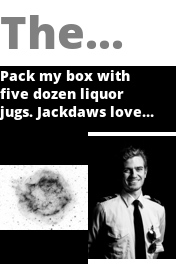

In [33]:
mylayout_non = Layout.Layout(resolution=epd2in7.resolution, layout=l)
mylayout_non.layout = l
mylayout_non.update_contents(u1)
mylayout_non.concat()

In [30]:
epd2in7.initEPD()
epd2in7.clearEPD()

DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release
INFO:root:epd initialized
DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release
INFO:root:epd initialized
DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release


True

In [34]:
epd2in7.initEPD()
epd2in7.writeEPD(mylayout_non.image)

DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release
INFO:root:epd initialized
DEBUG:root:Horizontal
DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release
INFO:root:epd initialized
DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release


In [ ]:
epd2in7.one_bit_display

In [ ]:
s = Screen(epd='HD', vcom=-1.93, mode='L', rotation=0)

In [ ]:
mylayout_hd = Layout.Layout(resolution=s.resolution, layout=l)
mylayout_hd.update_contents(u1)
mylayout_hd.concat()

In [ ]:
mylayout_hd.update_contents(u1)
mylayout_hd.concat()
s.writeEPD(mylayout_hd.image, sleep=True)

In [ ]:
s.rotation = 90

In [ ]:
s.writeEPD(image=mylayout_hd.image, sleep=False)

In [ ]:
# s.initEPD()
s.clearEPD()

In [15]:
logger = logging.getLogger(__name__)
logger.root.setLevel('DEBUG')